# Sequence To Sequence Model

# Sequence to Sequence Learning

In sequence-to-sequence learning we want to convert input sequences, in the general case of arbitraty length, to sequences in another domain. An obvious application of this is machine translation.

'Go on.'(English) -> [Sequence to Sequence Model] -> 'Mach weiter.'(German)

# What is Seq2Seq?
 
This model is a direct application of LSTM.The idea is to use one LSTM to read the input sequence, one timestep at a time, to obtain large fixed dimensional vector representation (also known as context vector), and then to use another LSTM to extract the output sequence.
This model (also known as seq2seq) was proposed in the context of machine translation.

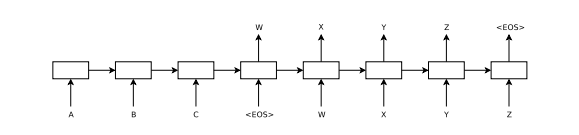

              Figure1 :Our model reads the ABC input sequence and outputs the WXYZ sequence.Here W is the context vector
                             

# Architecture

The most common architecture used to run se2seq is Encoder-Decoder architecture.As the name suggest it consist of :

 .Encoder
 .Decoder
 .Context Vector (internal states(cell state and hidden state) of Encoder LSTM)
 
 # Encoder
 
Encoder reads the input sequence and summarizes the information in something called the internal state vectors or context vector (in case of LSTM these are called the hidden state and cell state vectors).
Output of encoders is discarded, only the context vector is preserved. 

 # Context Vector Purpose

Context vector aims to encapsulate the information for all input elements in order to help the decoder make accurate predictions.


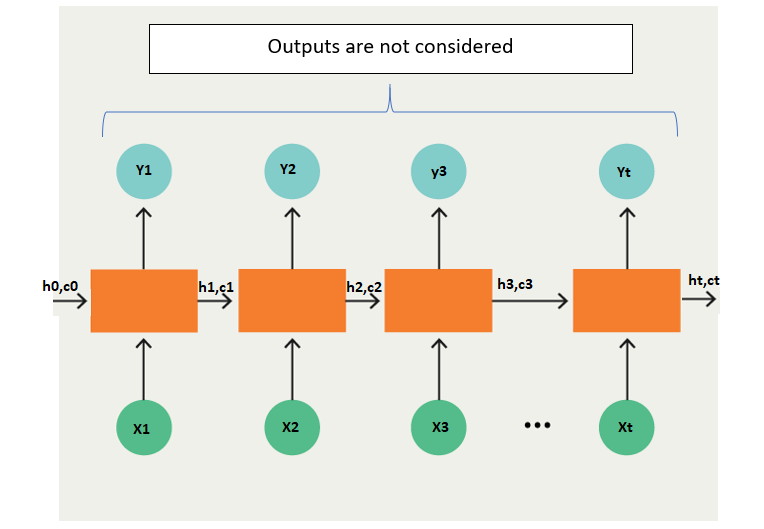


                                  Figure2: Encoder where X(t) is the input at timestep t and h(t),c(t) 
                                           are hidden state and cell state at timestep t and y(t) is the output

The hidden states h_i are computed using the formula:
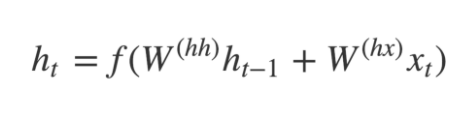

 # Decoder
 
The decoder is an LSTM whose initial states are initialized to the final states of the Encoder LSTM, i.e. the context vector of the encoder’s final cell is input to the first cell of the decoder network.

Using these initial states,the decoder starts generating the output sequence

A stack of several LSTM units where each predicts an output y_t at a time step t.

Any hidden state h_i is computed using the formula:
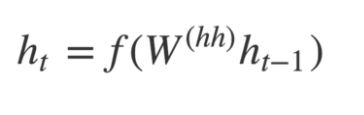

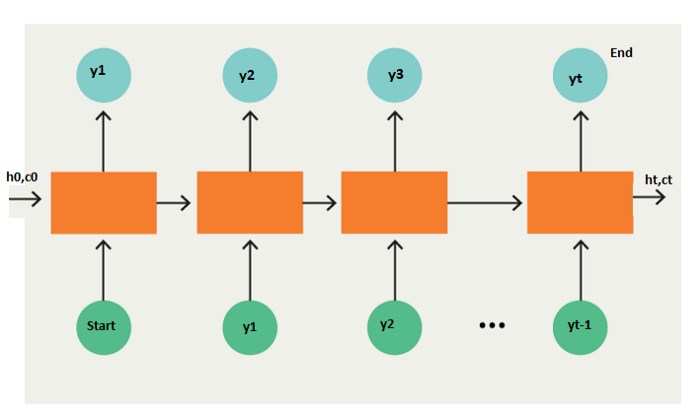

               Figure3:Decoder where h0,c0 are internal states of encoder and start (start of ouput sequence) 
                                 and y1,y2 and yt are outputs

# Uses of encoder and decoder

For,
Machine translation
Text summarization (where a sequence of input is given and output is another sequence (summarized text))
Answering questions (Chatbots)'

# Character by Character Processing

The model we're building will be processing the English sentences as a sequence of characters and produce the translated sentences character by character.

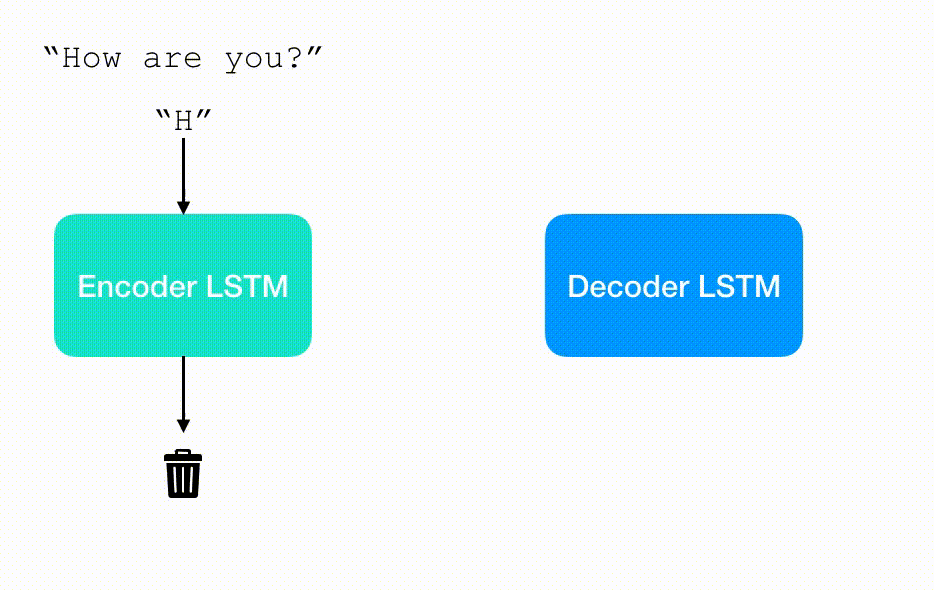

                        A schematic overview of the encoder-decoder model for machine translation.

# Importing Libraries

In [76]:
import keras, tensorflow
from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

# Working of Seq2Seq

# 1.Data Preparation

We have downloaded German-English dataset from http://www.manythings.org/anki/.They all consist of sentence pairs delimited by tabs. 

In [77]:
with open("deu-eng/deu.txt", 'r', encoding='utf-8') as f:
  lines = f.read().split('\n')

In [78]:
print(lines[144])
file = open("deu-eng/deu_1.txt", 'w', encoding='utf-8')
for line in lines:
    line = line.split("CC-")[0]
    file.write(line)
    file.write("\n")

Come on!	Macht schon!	CC-BY 2.0 (France) Attribution: tatoeba.org #24697 (CK) & #5362935 (RandomUsername)


In [79]:
#Creating list of lines by splitting at every occurance of '\n'.
with open("deu-eng/deu_1.txt", 'r', encoding='utf-8') as f:
  lines = f.read().split('\n')
lines[144]

'Come on!\tMacht schon!\t'

In [80]:
len(lines)

255819

In [81]:
#for spliting the input into input (English Sentence) and output (German Sentence)
input_texts = []
target_texts = []
#Since implementing the model character by character, therefore for computing set of character we encounter in input or target
input_characters = set()
target_characters = set()

In [82]:
#sample size
num_samples = 10000
num_samples

10000

In [83]:
for line in lines[: min(num_samples, len(lines) - 1)]:
    #splitting each line at '\t'
  ans_line= line.split('\t')
  input_text=ans_line[0]
  target_text=ans_line[1]
# adding '\t' (start-of-sequence) and '\n' (end-of-sequence) characters to every target text. 
  target_text = '\t' + target_text + '\n'
  input_texts.append(input_text)
  target_texts.append(target_text)
    #adding characters in sets from input and target texts
  for char in input_text:
    if char not in input_characters:
      input_characters.add(char)
  for char in target_text:
    if char not in target_characters:
      target_characters.add(char)

In [84]:
input_texts[144]

'Go away!'

In [86]:
target_texts[144]

'\tMacht schon!\n'

In [87]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)
#longest target sequence in the 10000 sample sentences, contains 51 characters,
#while the longest input sequence only contains 15.

Number of samples: 10000
Number of unique input tokens: 70
Number of unique output tokens: 83
Max sequence length for inputs: 15
Max sequence length for outputs: 51


In [93]:
print(input_characters)

[' ', '!', '"', '$', '%', "'", ',', '-', '.', '0', '1', '2', '3', '4', '5', '7', '8', '9', ':', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [94]:
print(target_characters)

['\t', '\n', ' ', '!', '$', '%', "'", ',', '-', '.', '0', '1', '2', '3', '4', '5', '7', '8', '9', ':', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\xa0', 'Ä', 'Ö', 'Ü', 'ß', 'ä', 'ö', 'ü', '’', '“', '„', '\u202f']


In [91]:
#tokenizing characters by assigning each unique character to an integer value
input_token_index = dict(
  [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
  [(char, i) for i, char in enumerate(target_characters)])

In [92]:
print(input_token_index)

{' ': 0, '!': 1, '"': 2, '$': 3, '%': 4, "'": 5, ',': 6, '-': 7, '.': 8, '0': 9, '1': 10, '2': 11, '3': 12, '4': 13, '5': 14, '7': 15, '8': 16, '9': 17, ':': 18, '?': 19, 'A': 20, 'B': 21, 'C': 22, 'D': 23, 'E': 24, 'F': 25, 'G': 26, 'H': 27, 'I': 28, 'J': 29, 'K': 30, 'L': 31, 'M': 32, 'N': 33, 'O': 34, 'P': 35, 'Q': 36, 'R': 37, 'S': 38, 'T': 39, 'U': 40, 'V': 41, 'W': 42, 'Y': 43, 'a': 44, 'b': 45, 'c': 46, 'd': 47, 'e': 48, 'f': 49, 'g': 50, 'h': 51, 'i': 52, 'j': 53, 'k': 54, 'l': 55, 'm': 56, 'n': 57, 'o': 58, 'p': 59, 'q': 60, 'r': 61, 's': 62, 't': 63, 'u': 64, 'v': 65, 'w': 66, 'x': 67, 'y': 68, 'z': 69}


In [88]:
#for conversion into one hot encoding
encoder_input_data = np.zeros(
  (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
  dtype='float32')
decoder_input_data = np.zeros(
  (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
  dtype='float32')
decoder_target_data = np.zeros(
  (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
  dtype='float32')

In [89]:
encoder_input_data.shape

(10000, 15, 70)

In [90]:
decoder_input_data.shape

(10000, 51, 83)

# Teacher Forcing

A common technique in training Recurrent Neural Networks

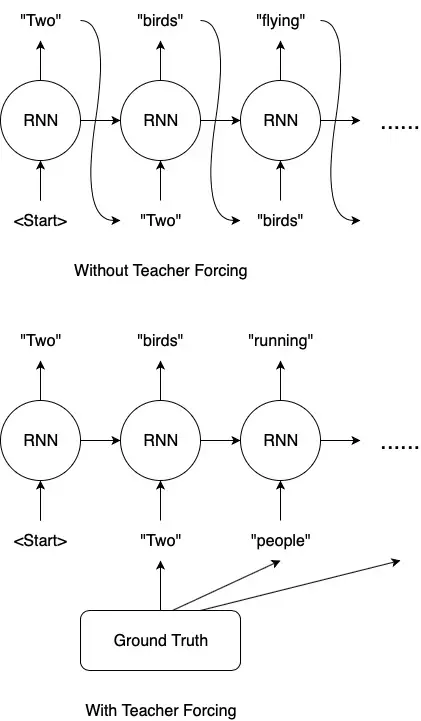


# Without Teacher Forcing
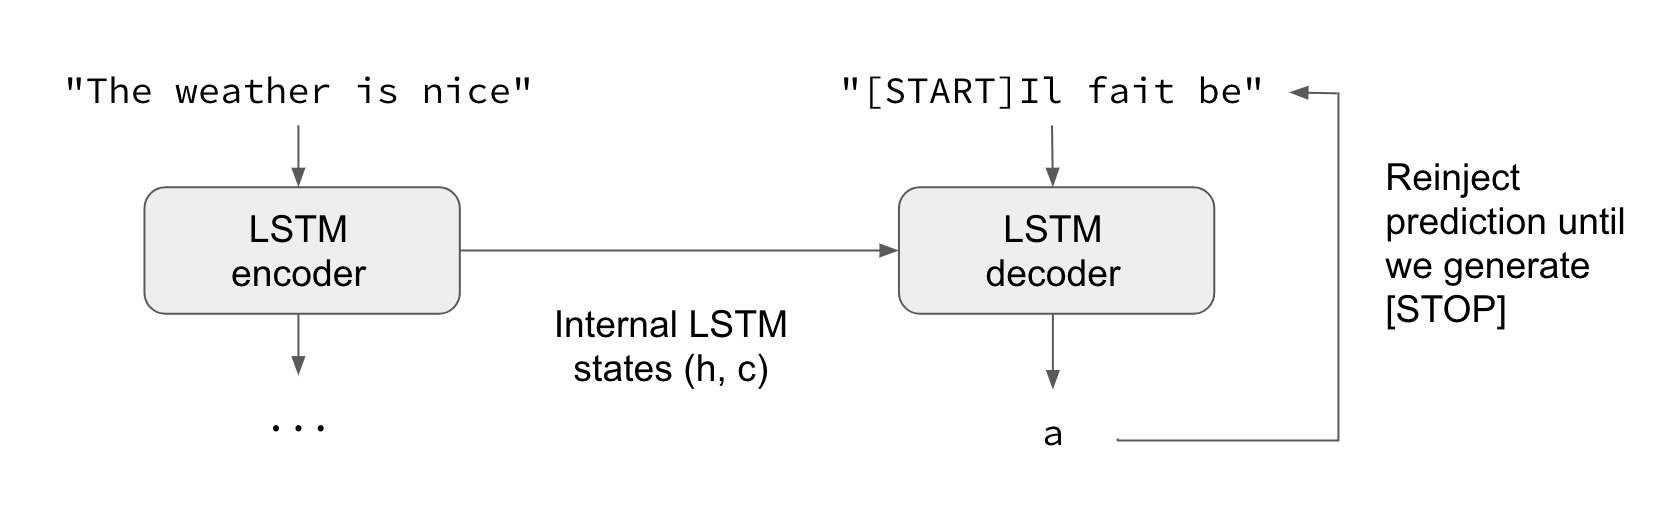
    Figure:The same process can also be used to train a Seq2Seq network without "teacher forcing",
           i.e. by reinjecting the decoder's predictions into the decoder.

In [96]:
#iterating over input and target text and creating respective one hot encoding
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
  for t, char in enumerate(input_text):
    encoder_input_data[i, t, input_token_index[char]] = 1.
  for t, char in enumerate(target_text):
    # decoder_target_data is ahead of decoder_input_data by one timestep
    decoder_input_data[i, t, target_token_index[char]] = 1.
    if t > 0:
      # decoder_target_data will be ahead by one timestep
      # and will not include the start character.
      decoder_target_data[i, t - 1, target_token_index[char]] = 1.

In [95]:
#Turning sentences into a sequence of length 16 with one-hot encodings of tokens for every character.
encoder_input_data[155].shape

(15, 70)

# 2.Building the Model

In [97]:
#Hyper-parameters for the model

batch_size = 64  # batch size for training
epochs = 100  # number of epochs to train for
latent_dim = 256  # latent dimensionality of the encoding space

In [98]:
#constructing encoder part for the model
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)#return state return the last hidden and cell state of encoder
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

Predicting individual characters from the decoder's output we attach a Dense layer to the decoder's LSTM outputs and usingsoftmax activation for the dense layer's outputs.
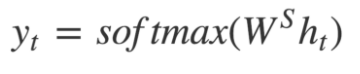

In [99]:
#constructing decoder part for the model
decoder_inputs = Input(shape=(None, num_decoder_tokens))
#return the hidden and cell state of all hidden layers
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')#Desnse layer
decoder_outputs = decoder_dense(decoder_outputs)

In [64]:
#using keras' Model fucntional API
#specifying the inputs, resulting model will include all the layers for computing outputs
model = Model(inputs=[encoder_inputs, decoder_inputs], 
              outputs=decoder_outputs)

# 3.Training the Model

In [65]:
#rmsprop similar to gradient descent. Increasing learning rate ->fast convergence
model.compile(optimizer='rmsprop', loss='categorical_crossentropy') 
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 70)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 83)]   0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 256),        334848      ['input_1[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

In [66]:
#running the training
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
model.save('seq2seq_eng-ger.h5')


Epoch 1/100
250/250 [==============================] - 184s 691ms/step - loss: 1.0866 - val_loss: 1.1124
Epoch 2/100
250/250 [==============================] - 128s 514ms/step - loss: 0.9508 - val_loss: 1.0479
Epoch 3/100
250/250 [==============================] - 132s 529ms/step - loss: 0.8693 - val_loss: 0.9381
Epoch 4/100
250/250 [==============================] - 129s 514ms/step - loss: 0.8114 - val_loss: 0.8913
Epoch 5/100
250/250 [==============================] - 127s 507ms/step - loss: 0.7655 - val_loss: 0.8182
Epoch 6/100
250/250 [==============================] - 127s 507ms/step - loss: 0.7287 - val_loss: 0.8123
Epoch 7/100
250/250 [==============================] - 127s 508ms/step - loss: 0.7000 - val_loss: 0.8218
Epoch 8/100
250/250 [==============================] - 126s 504ms/step - loss: 0.6725 - val_loss: 0.7657
Epoch 9/100
250/250 [==============================] - 126s 504ms/step - loss: 0.6406 - val_loss: 0.7034
Epoch 10/100
250/250 [==============================] -

# 4.Testing Machine Translation

In [101]:
#inference Mode
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.load_weights('seq2seq_eng-ger.h5')

In [102]:
#Run the decoder using just the start-of-sequence character as input and encoder internal states as the decoder's initial states.
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(
  decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
  [decoder_inputs] + decoder_states_inputs,
  [decoder_outputs] + decoder_states)

In [103]:
# reverse-lookup token index to turn sequences back to characters
reverse_input_char_index = dict(
  (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
  (i, char) for char, i in target_token_index.items())

In [104]:
def decode_sequence(input_seq):
  # encode the input sequence to get the internal state vectors.
  states_value = encoder_model.predict(input_seq)
  
  # generate empty target sequence of length 1 with only the start character
  target_seq = np.zeros((1, 1, num_decoder_tokens))
  target_seq[0, 0, target_token_index['\t']] = 1.
  
  # output sequence loop
  stop_condition = False
  decoded_sentence = ''
  while not stop_condition:
    output_tokens, h, c = decoder_model.predict(
      [target_seq] + states_value)
    
    # sample a token and add the corresponding character to the 
    # decoded sequence
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = reverse_target_char_index[sampled_token_index]
    decoded_sentence += sampled_char
    
    # check for the exit condition: either hitting max length
    # or predicting the 'stop' character
    if (sampled_char == '\n' or 
        len(decoded_sentence) > max_decoder_seq_length):
      stop_condition = True
      
    # update the target sequence (length 1).
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, sampled_token_index] = 1.
    
    # update states
    states_value = [h, c]
    
  return decoded_sentence

In [105]:
#examples from training set
for seq_index in range(10):
  input_seq = encoder_input_data[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)
  print('-')
  print('Input sentence:', input_texts[seq_index])
  print('Decoded sentence:', decoded_sentence)

1/1 [==============================] - 0s 48ms/step
-
Input sentence: Go.
Decoded sentence: Geh.

1/1 [==============================] - 0s 51ms/step
-
Input sentence: Hi.
Decoded sentence: Halle.

1/1 [==============================] - 0s 57ms/step
-
Input sentence: Hi.
Decoded sentence: Halle.

1/1 [==============================] - 0s 51ms/step
-
Input sentence: Run!
Decoded sentence: Lauf.

1/1 [==============================] - 0s 26ms/step
-
Input sentence: Run.
Decoded sentence: Lauf.

1/1 [==============================] - 0s 57ms/step
-
Input sentence: Wow!
Decoded sentence: Worder ein.

1/1 [==============================] - 0s 59ms/step
-
Input sentence: Wow!
Decoded sentence: Worder ein.

1/1 [==============================] - 0s 56ms/step
-
Input sentence: Duck!
Decoded sentence: Kom ich ein an.

1/1 [==============================] - 0s 48ms/step
-
Input sentence: Fire!
Decoded sentence: Feieen.

1/1 [==============================] - 0s 48ms/step
-
Input sentence: Help!


In [72]:
input_sentence = "How are you?"
test_sentence_tokenized = np.zeros(
  (1, max_encoder_seq_length, num_encoder_tokens), dtype='float32')
for t, char in enumerate(input_sentence):
  test_sentence_tokenized[0, t, input_token_index[char]] = 1.
print(input_sentence)
print(decode_sequence(test_sentence_tokenized))

How are you?
1/1 [==============================] - 0s 51ms/step
Wie geht es dun.



In [74]:
val_input_texts = []
val_target_texts = []
line_ix = 12000
for line in lines[line_ix:line_ix+10]:
  ans_line= line.split('\t')
  input_text=ans_line[0]
  target_text=ans_line[1]
  val_input_texts.append(input_text)
  val_target_texts.append(target_text)

val_encoder_input_data = np.zeros(
  (len(val_input_texts), max([len(txt) for txt in val_input_texts]),
   num_encoder_tokens), dtype='float32')

for i, input_text in enumerate(val_input_texts):
  for t, char in enumerate(input_text):
    val_encoder_input_data[i, t, input_token_index[char]] = 1.

In [75]:
for seq_index in range(10):
  input_seq = val_encoder_input_data[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)
  print('-')
  print('Input sentence:', val_input_texts[seq_index])
  print('Decoded sentence:', decoded_sentence[:-1])
  print('Ground Truth sentence:', val_target_texts[seq_index])

1/1 [==============================] - 0s 59ms/step
-
Input sentence: Boys are stupid.
Decoded sentence: Seigen Sie sich mal in der Schllene.
Ground Truth sentence: Jungen sind blöd!
1/1 [==============================] - 0s 45ms/step
-
Input sentence: Boys are stupid.
Decoded sentence: Seigen Sie sich mal in der Schllene.
Ground Truth sentence: Jungs sind doof.
1/1 [==============================] - 0s 51ms/step
-
Input sentence: Bring Tom along.
Decoded sentence: Bringe sie michen.
Ground Truth sentence: Bring Tom mit.
1/1 [==============================] - 0s 51ms/step
-
Input sentence: Bring him to me.
Decoded sentence: Bringe sie mir einen.
Ground Truth sentence: Bring ihn zu mir!
1/1 [==============================] - 0s 51ms/step
-
Input sentence: Bring that here.
Decoded sentence: Bring es es aus.
Ground Truth sentence: Bring das her.
1/1 [==============================] - 0s 43ms/step
-
Input sentence: Brush your hair.
Decoded sentence: Verscheie dich auf.
Ground Truth sentenc

# DrawBacks of Classical Seq2Seq

1.Context vector cannot summarize the entire input efficiently as the input sequence gets large.
2.The longer the sequence, the deeper is the neural network and deeper the neural network harder is it to train.(Vanishing gradient problem occur even with lstm)

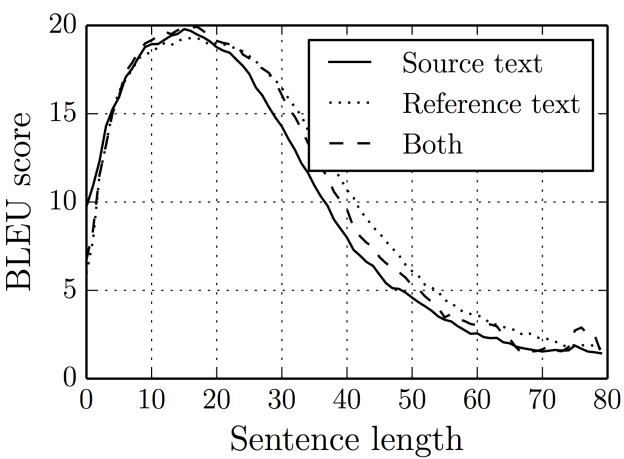

                    Figure: BLEU(Bi-Lingual Evaluation Understudy)A metric for evaluating machine-translated text
                          The diagram clearly predicts longer the sequence gets,more the curve reaches near zero
 
 # Solution
 
 Sequence to Sequence Model with Attention